# Time Series Clustering SAX - symbolic aggregate approximation and PAA - piecewise aggregate approximation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.manifold import MDS
import string

# Set random seed for reproducibility
np.random.seed(42)

# Function to simulate store data with different patterns
def simulate_store_data(n_stores=10, n_days=365):
    # Create date range
    start_date = datetime(2022, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(n_days)]
    
    # Create different store patterns
    store_data = {}
    
    # Pattern types
    patterns = ['increasing', 'decreasing', 'seasonal', 'weekend_peak', 'stable', 
                'increasing_seasonal', 'decreasing_seasonal', 'volatile', 'promotional', 'cyclical']
    
    for i in range(n_stores):
        pattern = patterns[i % len(patterns)]
        base_sales = np.random.randint(100, 500)
        noise_level = np.random.uniform(0.05, 0.2)
        trend_strength = np.random.uniform(0.1, 0.3)
        seasonal_strength = np.random.uniform(0.2, 0.4)
        
        # Generate time series based on pattern
        sales = np.zeros(n_days)
        t = np.arange(n_days)
        
        if pattern == 'increasing':
            sales = base_sales + trend_strength * t + noise_level * base_sales * np.random.randn(n_days)
        
        elif pattern == 'decreasing':
            sales = base_sales + base_sales - trend_strength * t + noise_level * base_sales * np.random.randn(n_days)
        
        elif pattern == 'seasonal':
            sales = base_sales + seasonal_strength * base_sales * np.sin(2 * np.pi * t / 365) + noise_level * base_sales * np.random.randn(n_days)
        
        elif pattern == 'weekend_peak':
            for j in range(n_days):
                day_of_week = (start_date.weekday() + j) % 7
                weekend_effect = 1.5 if day_of_week >= 5 else 1.0  # Higher sales on weekends
                sales[j] = base_sales * weekend_effect + noise_level * base_sales * np.random.randn()
        
        elif pattern == 'stable':
            sales = base_sales + noise_level * base_sales * np.random.randn(n_days)
        
        elif pattern == 'increasing_seasonal':
            sales = base_sales + trend_strength * t + seasonal_strength * base_sales * np.sin(2 * np.pi * t / 365) + noise_level * base_sales * np.random.randn(n_days)
        
        elif pattern == 'decreasing_seasonal':
            sales = base_sales + base_sales - trend_strength * t + seasonal_strength * base_sales * np.sin(2 * np.pi * t / 365) + noise_level * base_sales * np.random.randn(n_days)
        
        elif pattern == 'volatile':
            sales = base_sales + noise_level * 3 * base_sales * np.random.randn(n_days)
        
        elif pattern == 'promotional':
            sales = base_sales + noise_level * base_sales * np.random.randn(n_days)
            # Add promotional spikes
            promo_days = np.random.choice(n_days, size=int(n_days/30), replace=False)
            sales[promo_days] = sales[promo_days] * np.random.uniform(1.5, 3.0, size=len(promo_days))
        
        elif pattern == 'cyclical':
            sales = base_sales + base_sales * 0.4 * np.sin(2 * np.pi * t / 90) + noise_level * base_sales * np.random.randn(n_days)
        
        # Ensure no negative values
        sales = np.maximum(sales, 0)
        
        store_data[f'Store_{i+1}'] = {'sales': sales, 'pattern': pattern}
    
    # Create DataFrame
    df = pd.DataFrame({f'Store_{i+1}': store_data[f'Store_{i+1}']['sales'] for i in range(n_stores)})
    df['date'] = dates
    
    # Keep track of patterns for evaluation
    patterns_dict = {f'Store_{i+1}': store_data[f'Store_{i+1}']['pattern'] for i in range(n_stores)}
    
    return df, patterns_dict

# Function to implement Piecewise Aggregate Approximation (PAA)
def paa(series, num_segments):
    """Convert a time series into a PAA representation."""
    series = np.array(series)
    segment_length = len(series) // num_segments
    
    # Handle case where series length is not divisible by num_segments
    if len(series) % num_segments != 0:
        pad_length = num_segments - (len(series) % num_segments)
        series = np.pad(series, (0, pad_length), 'constant', constant_values=(0, series[-1]))
        segment_length = len(series) // num_segments
    
    paa_series = np.array([np.mean(series[i*segment_length:(i+1)*segment_length]) 
                          for i in range(num_segments)])
    
    return paa_series

# Function to implement Symbolic Aggregate Approximation (SAX)
def sax(paa_series, alphabet_size=10):
    """Convert a PAA representation into a symbolic string using SAX."""
    # Standardize the PAA series
    scaler = MinMaxScaler()
    normalized_paa = scaler.fit_transform(paa_series.reshape(-1, 1)).flatten()
    
    # Define the alphabet
    alphabet = list(string.ascii_lowercase[:alphabet_size])
    
    # Define breakpoints for equal-sized areas
    breakpoints = np.linspace(0, 1, alphabet_size + 1)
    
    # Convert PAA values to symbols
    sax_string = ''
    for val in normalized_paa:
        for i in range(len(breakpoints) - 1):
            if breakpoints[i] <= val < breakpoints[i + 1]:
                sax_string += alphabet[i]
                break
        else:  # For the case where val equals exactly 1.0
            sax_string += alphabet[-1]
    
    return sax_string

# Function to calculate distance between SAX strings
def sax_distance(str1, str2, alphabet_size=10):
    """Calculate the distance between two SAX strings."""
    if len(str1) != len(str2):
        raise ValueError("SAX strings must have the same length")
    
    alphabet = list(string.ascii_lowercase[:alphabet_size])
    distance = 0
    
    for char1, char2 in zip(str1, str2):
        idx1 = alphabet.index(char1)
        idx2 = alphabet.index(char2)
        distance += (idx1 - idx2) ** 2
    
    return np.sqrt(distance)

# Function to perform clustering
def cluster_stores(df, num_segments=12, alphabet_size=5, n_clusters=3):
    """Perform time series clustering using SAX and PAA."""
    # Extract store columns (excluding date)
    store_cols = [col for col in df.columns if 'Store' in col]
    
    # Apply PAA and SAX to each store's time series
    paa_representations = {}
    sax_strings = {}
    
    for store in store_cols:
        # Apply PAA
        paa_repr = paa(df[store].values, num_segments)
        paa_representations[store] = paa_repr
        
        # Apply SAX
        sax_str = sax(paa_repr, alphabet_size)
        sax_strings[store] = sax_str
    
    # Create distance matrix for clustering
    n_stores = len(store_cols)
    distance_matrix = np.zeros((n_stores, n_stores))
    
    for i, store1 in enumerate(store_cols):
        for j, store2 in enumerate(store_cols):
            distance_matrix[i, j] = sax_distance(sax_strings[store1], sax_strings[store2], alphabet_size)
    
    # Apply MDS to convert distance matrix to points in 2D space
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    points = mds.fit_transform(distance_matrix)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(points)
    
    # Create dictionary mapping stores to clusters
    clusters = {store: label for store, label in zip(store_cols, cluster_labels)}
    
    return clusters, sax_strings, points

# Function to visualize results
def visualize_results(df, clusters, patterns_dict, points):
    """Visualize the clustering results."""
    # Prepare data for plots
    store_cols = [col for col in df.columns if 'Store' in col]
    
    # 1. Plot the original time series colored by cluster
    plt.figure(figsize=(14, 8))
    for store in store_cols:
        cluster = clusters[store]
        plt.plot(df['date'], df[store], label=f"{store} (Cluster {cluster})", alpha=0.7)
    
    plt.title('Time Series by Cluster')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()
    
    # 2. Plot the clusters in 2D space
    plt.figure(figsize=(10, 8))
    cluster_labels = [clusters[store] for store in store_cols]
    
    # Create a colormap for clusters
    unique_clusters = set(cluster_labels)
    cluster_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    
    # Plot each point
    for i, (store, point) in enumerate(zip(store_cols, points)):
        cluster = clusters[store]
        color_idx = list(unique_clusters).index(cluster)
        plt.scatter(point[0], point[1], color=cluster_colors[color_idx], s=100, alpha=0.7)
        plt.text(point[0], point[1], store, fontsize=9)
    
    plt.title('Store Clusters in 2D Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Add a legend for clusters
    for cluster in unique_clusters:
        color_idx = list(unique_clusters).index(cluster)
        plt.scatter([], [], color=cluster_colors[color_idx], label=f'Cluster {cluster}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Compare clustering with actual patterns
    comparison_data = {
        'Store': store_cols,
        'Cluster': [clusters[store] for store in store_cols],
        'Pattern': [patterns_dict[store] for store in store_cols]
    }
    comparison_df = pd.DataFrame(comparison_data)
    
    # Plot as a heatmap
    plt.figure(figsize=(10, 8))
    cluster_pattern_counts = pd.crosstab(comparison_df['Cluster'], comparison_df['Pattern'])
    sns.heatmap(cluster_pattern_counts, annot=True, cmap='YlGnBu', fmt='d')
    plt.title('Comparison of Clusters vs. Actual Patterns')
    plt.tight_layout()
    plt.show()

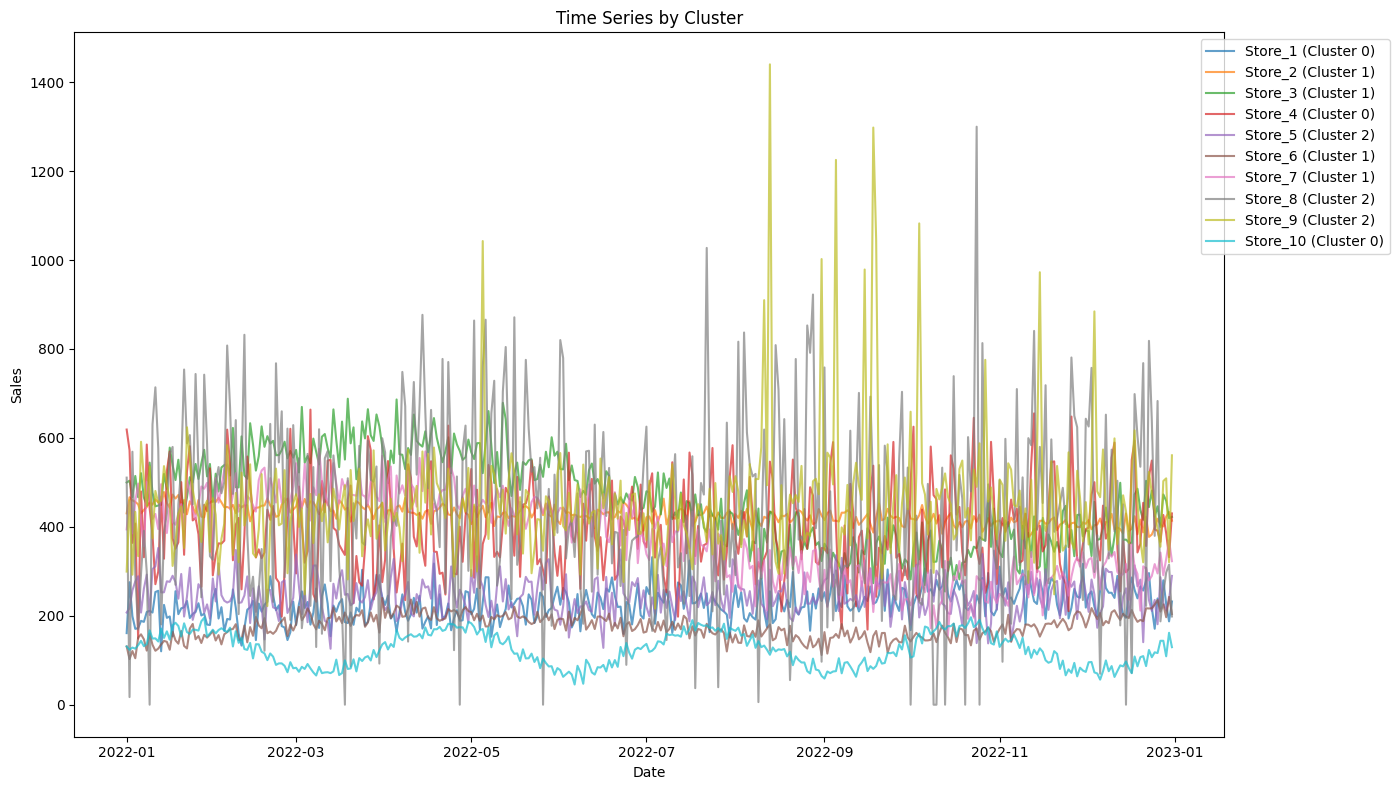

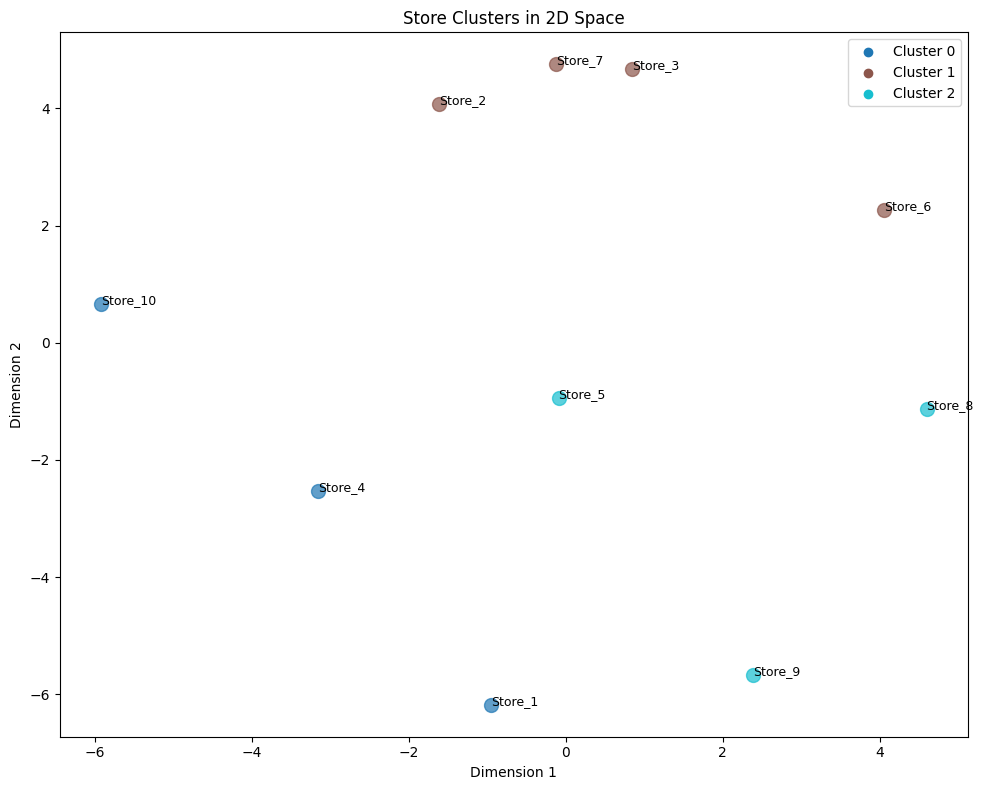

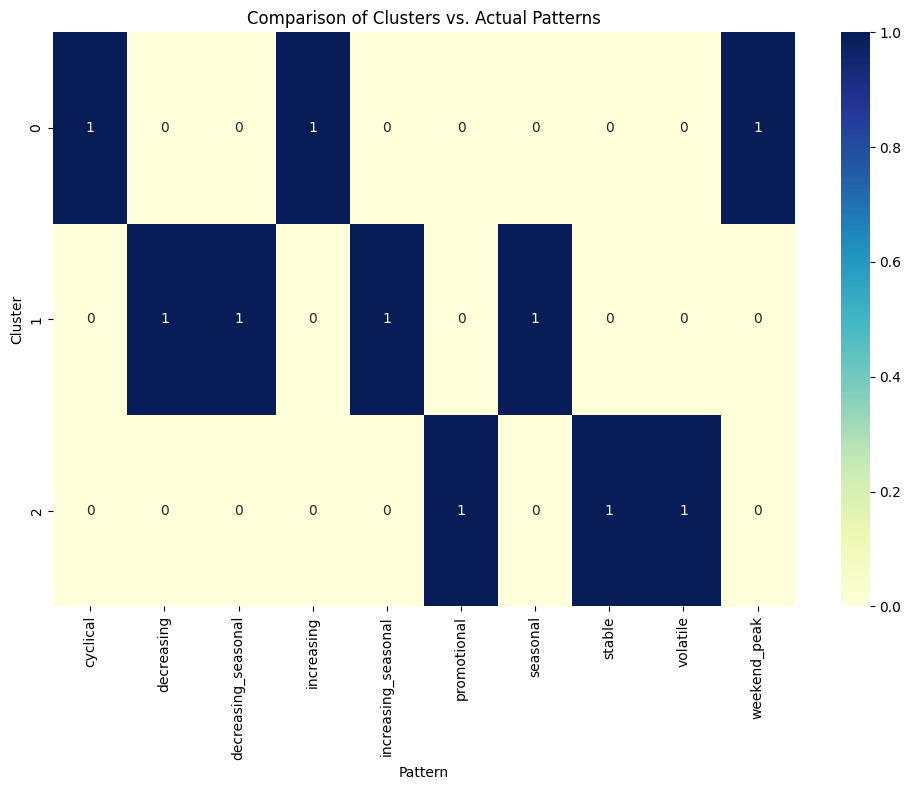

SAX Representations:
Store_1: aabaccccdeed
Store_2: eeedcccbbaaa
Store_3: deeeecbaaaab
Store_4: eccbddccaede
Store_5: eccccacccace
Store_6: aceeddbaabde
Store_7: deeeddcaaaab
Store_8: ccaeeabcaaea
Store_9: baabcaaeeccc
Store_10: ebaebaeaaeab


In [2]:
# Main execution
# 1. Simulate data for 10 stores
df, patterns_dict = simulate_store_data(n_stores=10, n_days=365)

# 2. Perform clustering
num_segments = 12  # One segment per month
alphabet_size = 5  # Using a-e
n_clusters = 3     # Number of clusters to form

clusters, sax_strings, points = cluster_stores(df, num_segments, alphabet_size, n_clusters)

# 3. Visualize results
visualize_results(df, clusters, patterns_dict, points)

# 4. Print SAX representations
print("SAX Representations:")
for store, sax_str in sax_strings.items():
    print(f"{store}: {sax_str}")